# Khám phá dữ liệu

Tạm thời dừng việc làm sạch dữ liệu, ta chuyển sang xem có thể rút ra được những nhận xét gì từ bộ data này.

Trước hết cứ load lại dữ liệu

In [1]:
# %load loaddata.py
import pandas as pd

pd.set_option('max.rows', 14)

data = pd.read_csv(
    'data/titanic.csv',
    index_col='PassengerId',
    usecols=lambda col: col not in ('Cabin', 'Ticket'),
    dtype={
        'Pclass': 'category',
        'Sex': 'category',
        'Embarked': 'category'
    }
)

data['Age'] = (data['Age'].fillna(data['Age'].mean())
                          .astype(int))
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)


In [ ]:
data.info()

Ngoài `info()` thì còn có hàm `describe()` mô tả cụ thể hơn

In [ ]:
data.describe()

Mặc định thì `describe()` chỉ mô tả các cột có kiểu dữ liệu số. Nếu muốn hiện hết thì có thể dùng parameter `include`

In [ ]:
data.describe(include='all')

Cũng có thể dùng `include` để chọn ra những loại dữ liệu cụ thể

In [2]:
import numpy as np

data.describe(include=[np.number, 'category'])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891,891,891.000000,891.000000,891.000000,891.000000,891
unique,NaN,3,2,NaN,NaN,NaN,NaN,3
top,NaN,3,male,NaN,NaN,NaN,NaN,S
freq,NaN,491,577,NaN,NaN,NaN,NaN,646
mean,0.383838,NaN,NaN,29.544332,0.523008,0.381594,32.204208,NaN
std,0.486592,NaN,NaN,13.013778,1.102743,0.806057,49.693429,NaN
min,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,NaN,NaN,22.000000,0.000000,0.000000,7.910400,NaN
50%,0.000000,NaN,NaN,29.000000,0.000000,0.000000,14.454200,NaN
75%,1.000000,NaN,NaN,35.000000,1.000000,0.000000,31.000000,NaN


### Exercise

Dùng `describe()` để mô tả riêng cột `Embarked`

In [ ]:
# Code vào đây

In [ ]:
%load solutions/describe_embarked.py

## Nhận biết các feature quan trọng

Câu hỏi quan trọng nhất trong bài toán này là "những yếu tố nào ảnh hưởng đến khả năng sống còn của 1 người trên tàu Titanic?". Để trả lời, ta có thể xem xét mối quan hệ giữa từng cột với cột `Survived`. Tuy nhiên ta cứ thử đưa ra 1 vài dự đoán trước:
- `Pclass`? Người có hạng vé cao có thể có ưu tiên áo phao
- `Sex`? Phụ nữ được ưu tiên, cái này khá chắc chắn
- `Age`? Mấy anh trẻ khỏe đương nhiên dễ sống hơn mấy ông già rồi
- `Name`? Có thể thấy tên bao gồm cả _title_, ví dụ `Capt`, `Lady`... thể hiện địa vị xã hội của người đó. Ngoài ra có thể lấy ra họ của từng người, từ đó đoán thêm 1 số thông tin như sắc tộc, xuất xứ...
- Số lượng anh em, vợ/chồng `SibSp`? Bố mẹ con cái `Parch`? Có thể vì cứu nhau mà cùng sống hoặc cùng chết.
- Giá vé `Fare`? Nếu giá vé quyết định khoang ở thì có thể có ảnh hưởng, vì có khoang chìm trước khoang chìm sau.
- Điểm lên tàu `Embarked`? Tương tự `Fare`, có thể nó có ảnh hưởng đến khoang ở trên tàu.

Hầu hết các cột đã ở dạng rất dễ tham chiếu, chỉ có cột `Name` là có nhiều data thừa. Tạm không đụng đến họ mà chỉ quan tâm đến title, ta nên bóc tách phần thông tin cần thiết ra để dễ tham chiếu sau này.

Ngoài ra, có thể tính được số người trong gia đình trên tàu bằng cách cộng `SibSp` và `Parch`

## Feature engineering

Trước hết ta cần 1 function để lấy được title từ tên người. Regular Expression là perfect cho việc này. Thư viện Regular Expression trong Python là `re`

In [3]:
import re

name_pattern = re.compile('.*, ([^.]*)\..*')

def get_title_from_name(name):
    m = name_pattern.match(name)
    if not m:
        raise ValueError(f'Name doesn\'t match pattern: {name}')
    return m.group(1)

# Test qua
for i in range(1, 10):
    print(get_title_from_name(data.loc[i, 'Name']))

Mr
Mrs
Miss
Mrs
Mr
Mr
Mr
Master
Mrs


Trông có vẻ ổn rồi. Giờ áp dụng trên toàn bộ cột `Name` để tạo ra cột mới `Title`

In [4]:
data['Title'] = data['Name'].apply(get_title_from_name).astype('category')
data['Title']

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
6        Mr
7        Mr
       ... 
885      Mr
886     Mrs
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Title, Length: 891, dtype: category
Categories (17, object): [Capt, Col, Don, Dr, ..., Ms, Rev, Sir, the Countess]

Cột `Name` đã không còn giá trị, xóa

In [5]:
data.drop(columns='Name', inplace=True)

Thử xem tần suất xuất hiện của từng title như thế nào

In [ ]:
with pd.option_context('max.rows', 20):
    print(data['Title'].value_counts())

Chú ý:
- `Mlle` (tiếng Pháp) = `Miss` (tiếng Anh), `Mme` (tiếng Pháp) = `Mrs` (tiếng Anh)
- Chỉ có 1 `Ms`, không đáng để để thành 1 category riêng, có thể ghép vào với `Miss`
- Ngoài `Mr`, `Miss`, `Mrs`, `Mlle`, `Mme`, `Ms` thì các title còn lại đều dành cho quý tộc/người được trọng vọng, và có tần suất xuất hiện rất thấp. Có thể gộp vào thành 1 category `High standing`

In [6]:
# Đổi Mlle, Ms -> Miss, Mme -> Mrs
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
data['Title'] = data['Title'].replace(['Mme'], 'Mrs')

with pd.option_context('max.rows', 20):
    print(data['Title'].value_counts())

Mr              517
Miss            185
Mrs             126
Master           40
Dr                7
Rev               6
Col               2
Major             2
Lady              1
Don               1
Jonkheer          1
the Countess      1
Sir               1
Capt              1
Mlle              0
Mme               0
Ms                0
Name: Title, dtype: int64


Các category còn lại thì lằng nhằng hơn do pandas không có hàm merge category. Có thể xóa toàn bộ các category này để biến các value tương ứng bị `null`, rồi điền `High standing` vào tất cả các chỗ `null`

In [7]:
data['Title'].cat.set_categories(('Mr', 'Mrs', 'Miss', 'High Standing'), inplace=True)
data['Title'].fillna('High Standing', inplace=True)
data['Title']

PassengerId
1                 Mr
2                Mrs
3               Miss
4                Mrs
5                 Mr
6                 Mr
7                 Mr
           ...      
885               Mr
886              Mrs
887    High Standing
888             Miss
889             Miss
890               Mr
891               Mr
Name: Title, Length: 891, dtype: category
Categories (4, object): [Mr, Mrs, Miss, High Standing]

### Exercise

Tạo thêm cột `FamilySize` sử dụng cột `SibSp` và `Parch`

In [ ]:
# Code vào đây

In [9]:
# %load solutions/create_family_size.py
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1  # Cộng thêm cả bản thân người đó nữa

## Visualize

Đã đến lúc xem xem những dự đoán ban đầu của chúng ta chính xác hay không. Ta sẽ so sánh từng cột với cột `Survived`

Để visualize data trong Python, có 2 thư viện phổ biến nhất là `matplotlib` và `seaborn`

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

### Pclass

In [16]:
pd.crosstab(data['Pclass'],data['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


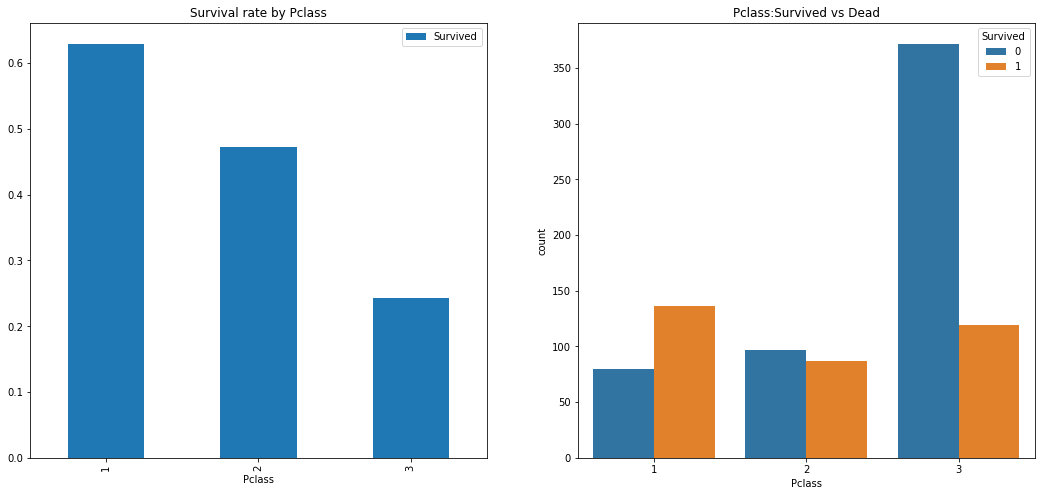

In [24]:
f, ax=plt.subplots(1, 2, figsize=(18, 8))
data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survival rate by Pclass')
sns.countplot('Pclass',hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead')
plt.show()

Có thể thấy mấy ông class 1 có tỉ lệ sống cao hơn chết, còn class 3 thì T__T. Có tiền có khác!

### Sex

In [17]:
pd.crosstab(data['Sex'],data['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


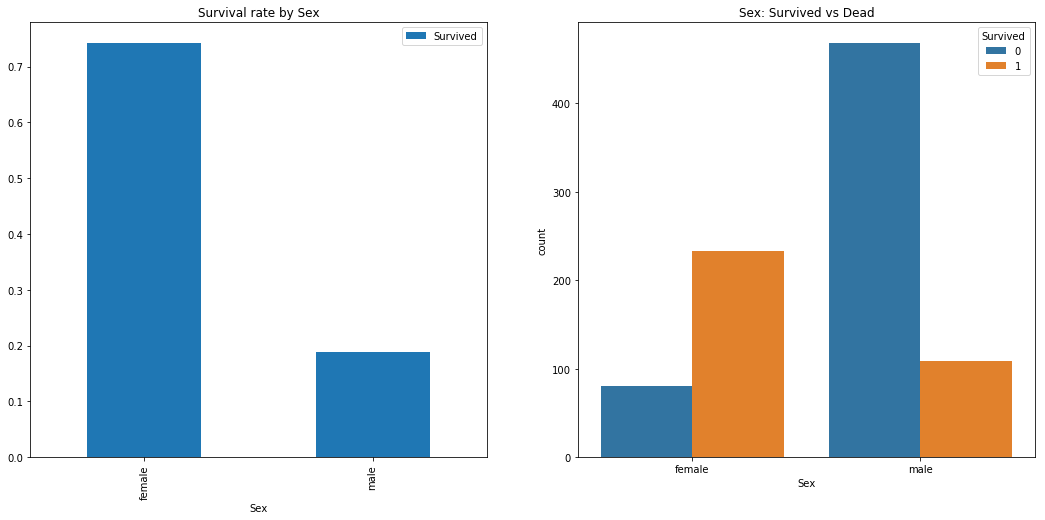

In [25]:
f, ax=plt.subplots(1, 2, figsize=(18, 8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survival rate by Sex')
sns.countplot('Sex',hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

Đúng là nữ giới được ưu tiên hơn. Cỡ 75% nữ sống trong khi nam chỉ được tầm 20%.